# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
def P1(num_examples=5):
    for i in range(num_examples):
        print (color.BOLD + "Message for example number {0} with label {1} ({2}) is".format(i, train_labels[i], newsgroups_train.target_names[train_labels[i]]) + color.END)
        print(color.BLUE + train_data[i] + color.END)
        print()
P1(5)

Message for example number 0 with label 1 (comp.graphics) is
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Message for example number 1 with label 3 (talk.religion.misc) is


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like 

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    # by default, analyzer is word - so we have word n-grams
    vectorizer = CountVectorizer()
    vec_result = vectorizer.fit_transform(train_data)
    
    print(color.BOLD + "[Standard]" + color.END + " The size of the vocabulary is {0}".format(len(vectorizer.vocabulary_)))
    # print(vec_result.toarray())
    
    print(color.BOLD + "[Standard]" + color.END + " The first feature alphabetically is {0}".format(vectorizer.get_feature_names()[0]))
    print(color.BOLD + "[Standard]" + color.END + " The last feature alphabetically is {0}".format(vectorizer.get_feature_names()[-1]))
    
    # count all non zero elements per example in the result vector
    nonzero = np.count_nonzero(vec_result.toarray(), axis=1)
    all_counts =  vec_result.toarray().shape[0] * vec_result.toarray().shape[1] 
    
    print(color.BOLD + "[Standard]" + color.END + " The average number of non-zero features per example is {0}".format(np.average(nonzero)))
    print(color.BOLD + "[Standard]" + color.END + " The fraction of the non-zero entries in the matrix is {0}".format(np.sum(nonzero)/all_counts))
    
    custom_vocab = ["atheism", "graphics", "space", "religion"]
    vectorizer = CountVectorizer(vocabulary=custom_vocab)
    vec_result = vectorizer.transform(train_data)
    print(color.BOLD + "[Custom Vocab]" + color.END +" The custom vocab size is {0} and expected size is {1}".format(len(vectorizer.vocabulary_), len(custom_vocab)))
    print(vectorizer.vocabulary_)
    
    nonzero = np.count_nonzero(vec_result.toarray(), axis=1)
    print(color.BOLD + "[Custom Vocab]" + color.END +" The average number of non-zero features per example is {0}".format(np.average(nonzero)))

    # make analyzer to be string, so we have char n-grams
    vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,3))
    vec_result = vectorizer.fit_transform(train_data)
    print(color.BOLD + "[Character n-grams]" + color.END + " The size of the vocabulary is {0}".format(len(vectorizer.vocabulary_)))
    
    # prune words that appear in fewer than 10 docs
    vectorizer = CountVectorizer(min_df=10)
    vec_result = vectorizer.fit_transform(train_data)
    print(color.BOLD + "[Min word freq]" + color.END + " The size of the vocabulary is {0}".format(len(vectorizer.vocabulary_)))
    
    vectorizer_train = CountVectorizer()
    vec_result_train = vectorizer_train.fit_transform(train_data)

    vectorizer_dev = CountVectorizer()
    vec_result_dev = vectorizer_dev.fit_transform(dev_data)
    
    diffkeys = [k for k in vectorizer_dev.vocabulary_ if k not in vectorizer_train.vocabulary_]
    print("Fraction of words in dev vocab that are not in the training vocab are {0}".format(len(diffkeys)/len(vectorizer_dev.vocabulary_)))
    

P2()

[Standard] The size of the vocabulary is 26879
[Standard] The first feature alphabetically is 00
[Standard] The last feature alphabetically is zyxel
[Standard] The average number of non-zero features per example is 96.70599803343165
[Standard] The fraction of the non-zero entries in the matrix is 0.0035978272269590263
[Custom Vocab] The custom vocab size is 4 and expected size is 4
{'atheism': 0, 'graphics': 1, 'space': 2, 'religion': 3}
[Custom Vocab] The average number of non-zero features per example is 0.26843657817109146
[Character n-grams] The size of the vocabulary is 35478
[Min word freq] The size of the vocabulary is 3064
Fraction of words in dev vocab that are not in the training vocab are 0.24787640034470024


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
from collections import defaultdict

def knn_helper(k_values, train_set, dev_set, train_y, dev_y, verbose=True):
    f1_score = defaultdict(list)
    
    # define knn model
    for k in k_values:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(train_set, train_y)
        predictions = neigh.predict(dev_set)
        f1_score[k] = metrics.f1_score(dev_y, predictions, average="weighted")
    
    if verbose:
        for k in k_values:
            print(color.BOLD + "[KNN]" + color.END + " For k ={0}, the F1 score is {1}".format(k, f1_score[k]))
            
    return f1_score

def multinomial_nb_helper(alphas, train_set, dev_set, train_y, dev_y, verbose=True):
    f1_score = defaultdict(list)
    
    for a in alphas:
        clf = MultinomialNB(alpha=a)
        clf.fit(train_set, train_y)
        predictions = clf.predict(dev_set)
        f1_score[a] = metrics.f1_score(dev_y, predictions, average="weighted")

    if verbose:
        for a in alphas:
            print(color.BOLD + "[MultiNomial NB]" + color.END + " For alpha ={0}, the F1 score is {1}".format(a, f1_score[a]))
    
    return f1_score

def logistic_reg_helper(l2_reg, train_set, dev_set, train_y, dev_y, max_iteration=100, verbose=True):
    result = defaultdict(list)
    
    for l2 in l2_reg:
        clf = LogisticRegression(C=l2, solver="liblinear", multi_class="auto", max_iter=max_iteration)
        clf.fit(train_set, train_y)
        predictions = clf.predict(dev_set)
        
        # add relevant attributes for logit to result
        result[l2].append(metrics.f1_score(dev_y, predictions, average="weighted"))
        result[l2].append(np.sum(clf.coef_ ** 2, axis=1))
        result[l2].append(clf.coef_)
        result[l2].append(clf.predict_proba(dev_set))
        result[l2].append(predictions)
        
    if verbose:
        for l2 in l2_reg:
            print(color.BOLD + "[Logistic Regression]" + color.END + " For C ={0}, F1 score: {1}, SSQ: {2}".format(l2, result[l2][0], result[l2][1]))
    
    return result
    
def P3():
    # prepare dataset
    vec = CountVectorizer()
    vec_result_train = vec.fit_transform(train_data)
    
    vec = CountVectorizer(vocabulary=vec.get_feature_names())
    vec_result_dev = vec.transform(dev_data)
    
    print("Shape of the training set is {0}".format(str(vec_result_train.toarray().shape)))
    print("Shape of the dev set is {0}".format(str(vec_result_dev.toarray().shape)))
    
    # perform knn
    knn_helper([i for i in range(1, 20, 3)], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    print()
    
    # perform multinomial nb
    multinomial_nb_helper([1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    print()
    
    # perform logistic regression
    logistic_reg_helper([1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 1.0, 2.0, 10.0, 50, 100], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    print()
    
P3()

Shape of the training set is (2034, 26879)
Shape of the dev set is (676, 26879)
[KNN] For k =1, the F1 score is 0.39471048126424524
[KNN] For k =4, the F1 score is 0.44061615064622817
[KNN] For k =7, the F1 score is 0.46603879404544657
[KNN] For k =10, the F1 score is 0.4444765532323276
[KNN] For k =13, the F1 score is 0.4273744719838095
[KNN] For k =16, the F1 score is 0.43002170039301457
[KNN] For k =19, the F1 score is 0.43352736669578024

[MultiNomial NB] For alpha =1e-10, the F1 score is 0.747240657284563
[MultiNomial NB] For alpha =0.0001, the F1 score is 0.7628348704826354
[MultiNomial NB] For alpha =0.001, the F1 score is 0.7702518836155706
[MultiNomial NB] For alpha =0.01, the F1 score is 0.7751663218544357
[MultiNomial NB] For alpha =0.1, the F1 score is 0.7903052385098862
[MultiNomial NB] For alpha =0.5, the F1 score is 0.7862862961995258
[MultiNomial NB] For alpha =1.0, the F1 score is 0.7777320236017224
[MultiNomial NB] For alpha =2.0, the F1 score is 0.7689966472342658
[M

C:\Users\abhisha.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Logistic Regression] For C =1e-10, F1 score: 0.20641155283594254, SSQ: [5.70674183e-13 8.45299474e-13 4.04006981e-13 6.35819484e-13]
[Logistic Regression] For C =0.0001, F1 score: 0.5416003218838589, SSQ: [0.00770175 0.0119412  0.00943508 0.00910284]
[Logistic Regression] For C =0.001, F1 score: 0.6193046812006844, SSQ: [0.16509345 0.20095275 0.18067094 0.18724278]
[Logistic Regression] For C =0.01, F1 score: 0.6646997417582748, SSQ: [2.54149597 2.93970937 2.86246884 2.25002867]
[Logistic Regression] For C =0.1, F1 score: 0.6966243542418833, SSQ: [27.13276422 24.65876272 27.45791178 23.02092251]
[Logistic Regression] For C =0.5, F1 score: 0.7084739776490449, SSQ: [102.60222594  83.1201744   99.01364429  88.98434638]
[Logistic Regression] For C =0.7, F1 score: 0.6939142407011022, SSQ: [130.8094896  104.16699008 124.93573965 113.83960131]
[Logistic Regression] For C =1.0, F1 score: 0.6944172871853819, SSQ: [166.96406144 130.8904599  157.88282512 145.71125673]
[Logistic Regression] For C

ANSWER:

**KNN**

KNN doesnt perform as well due to the curse of dimensionality. As we notice, there are over 25k features in the model.
Due to this, not only does KNN run slowest of the 3 models, but its F score also suffers. The feature space is large and its hard to generalize well with small values of K (small compared to the size of the features). We can try to increase the value of K, however, beyond a threshold - increasing K will lose its meaning. For example, it would not be useful to consider (say) 10k neighbors for a data point for classification as its not useful to consider so many neighbors (because everyone is "close" and a neighbor at that point).

The peak value for KNN classification F score is around 0.46 at K=7

**Multinomial NB vs Logistic Regression**

https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c

The best performing logistic model is when C=0.50 with F1 score = 0.708

The best performing multinomial NB model is when alpha =0.1 with F1 score = 0.79

The above article describes that "when the training size reaches infinity the discriminative model, ie, logistic regression performs better than the generative model, ie, Naive Bayes. The generative model reaches its asymptotic faster (O(log n)) than the discriminative model (O(n)), ie, the generative model (Naive Bayes) reaches the asymptotic solution for fewer training sets than the discriminative model (Logistic Regression)". In our dataset, we have only around 2k training examples - which is relatively small, especially compared to the feature size. Thus, in such a setting NB performs better than logistic regression.


**Relationship between C and SSQ**

From the above, we can think of C as an inverse of the traditional regularization parameter, lambda. That is, when C is large, we're hardly regularizing the weights but when C is small, we are heavily regularizing the weights. Thus, during high regularization (C is small), we see smaller sum of squares on the weights - we're penalizing unnecessary features highly and being parsimonious. When C is large, we're allowing more features' weights to creep into the model, thus SSQ is large.


### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4(l2_reg = 0.5, num_features = 5, absolute=False):
    # prepare dataset
    vec = CountVectorizer(ngram_range=(2,2))
    vec_result_train = vec.fit_transform(train_data)
    

    vec1 = CountVectorizer(ngram_range=(2,2), vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.transform(dev_data)
    
    logit_result = logistic_reg_helper([l2_reg], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    
    # get the weights for each topic
    weights_topic = logit_result[l2_reg][2]
    if absolute:
        weights_topic = np.absolute(weights_topic)
        
    # print(weights_topic.shape)
    
    result = defaultdict(list)
    
    # sort the weights row wise for each topic to get indices
    ind_topic_sorted_by_wt = np.argsort(weights_topic, axis=1)
    
    # for each topic
    for i in range(len(newsgroups_train.target_names)):
        
        # get topic name, which will be the key of the "result" dict
        topic = newsgroups_train.target_names[i]
        # print("For index {0} the topic name is {1}".format(i, topic))
        
        # add indices corresponding to highest N weights (last N values)
        result[topic].append(list(ind_topic_sorted_by_wt[i][-num_features:]))
        
        wts = list()
        ngrams = list()
        
        for idx in result[topic][0]:
            # extract the weight corresponding to an index
            wts.append(weights_topic[i][idx])
            
            # not optimal method, but we need to extract the feature val against an index
            for k,v in vec1.vocabulary_.items():
                if idx == v:
                    ngrams.append(k)
        
        # add weight values corresponding to the highest N weights
        result[topic].append(wts)
        # add features (n grams) corresponding to the highest N weights
        result[topic].append(ngrams)
    
    for k,v in result.items():
        print()
        print(color.BOLD + k + color.END)
        print("[N Grams] top {0} are {1}".format(num_features, v[2]))
        print("[Indices] top {0} are {1}".format(num_features, v[0]))
        print("[Weights] top {0} are {1}".format(num_features, v[1]))


P4()
print()
print(color.RED + color.BOLD + "Rerun with only positive weights" + color.END)
P4(absolute=True)

[Logistic Regression] For C =0.5, F1 score: 0.607673237840669, SSQ: [111.75537598 118.73154706 123.42664907 100.53142283]

alt.atheism
[N Grams] top 5 are ['are you', 'you are', 'was just', 'cheers kent', 'claim that']
[Indices] top 5 are [20596, 193317, 184771, 37174, 38326]
[Weights] top 5 are [0.4469536835860547, 0.4727407210654848, 0.48205042880406834, 0.5557194352213277, 0.6055485515545411]

comp.graphics
[N Grams] top 5 are ['is there', 'out there', 'comp graphics', 'in advance', 'looking for']
[Indices] top 5 are [88596, 123709, 40451, 81950, 98723]
[Weights] top 5 are [0.754978454726191, 0.7586817661616276, 0.8012017496923247, 0.8325706146317984, 1.1083703054211937]

sci.space
[N Grams] top 5 are ['it was', 'and such', 'sci space', 'the moon', 'the space']
[Indices] top 5 are [90070, 16732, 145068, 165984, 167336]
[Weights] top 5 are [0.5253683051458958, 0.590505629590374, 0.6210528733099062, 0.8309978937975367, 0.8710667743882963]

talk.religion.misc
[N Grams] top 5 are ['of j

ANSWER:

As seen above, we have the n-grams (features) corresponding to the highest weights. An interesting analysis to conduct would be to see how the above answer changes when we look at absolute values of weights, compared to weights with signs.

Upon doing this analysis, we see the answer doesnt change much for the topics, however some topics start seeing "looking for" more often in their feature list. For example, "talk.religion.misc" is affected adversely, likely for the worse. Earlier, the topic consisted of ['of jesus', 'but he', 'ignorance is', 'cheers kent', 'the fbi'] - whereas with absolute weights, it looks like ['ignorance is', 'does anyone', 'cheers kent', 'the fbi', 'looking for']. We dropped the feature "of jesus" which we know is highly correlated with religion, to be replaced by a generic "looking for"



Surprising Features
1. "talk.religion.misc" has "the fbi" as a feature.
2. "cheers kent" shows up twice in the original model, and thrice in the re-run with positive weights only.
3. Some features are not very valuable such as "you are", "are you", "is there" - these are likely topic agnostic and dont provide any topic specific information, compared to say "the moon" in the space topic.
4. "looking for" is a pretty apt feature for comp.graphics as writers are often "looking for" answers or recommendations to solve computer problems - so its believable that most literature would consist of this term.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def better_preprocessor(s):
    # lowercase the input
    s = s.lower()
    
    ps = PorterStemmer()
    words = word_tokenize(s)
    new_s = ""
    for w in words:
        # remove all non alpha numeric values
        alphanumeric_filter = filter(str.isalnum, w)
        tmp = "".join(alphanumeric_filter)
        
        # replace all sequence of numbers with single num
        tmp = re.sub(r"[0-9]+","0", tmp)
        
        # stem the word using porter stemmer and add to new string
        new_s += ps.stem(tmp) + " "
    
    return new_s

def P5(l2_reg=0.5, ngram_range_param=(2,2)):
    print()
    print(color.RED + color.BOLD + "Evaluating for ngram size = {0} and C={1}".format(ngram_range_param, l2_reg) + color.END)
    vec = CountVectorizer(ngram_range= ngram_range_param)
    vec_result_train = vec.fit_transform(train_data)
    
    vec1 = CountVectorizer(ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.transform(dev_data)
    
    logit_result1 = logistic_reg_helper([l2_reg], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels, 400)
    
    print(color.BOLD + "[Original Model]"+ color.END +" F1 score is {0} with dictionary size {1}".format(logit_result1[l2_reg][0], len(vec.get_feature_names())))
    
    vec = CountVectorizer(preprocessor=better_preprocessor, ngram_range=ngram_range_param)
    vec_result_train = vec.fit_transform(train_data)

    vec1 = CountVectorizer(preprocessor=better_preprocessor, ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.transform(dev_data)
    
    logit_result2 = logistic_reg_helper([l2_reg], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels, 400)
    
    print(color.BOLD + "[Modified Model with Preprocessing]" + color.END + " F1 score is {0} with dictionary size {1}".format(logit_result2[l2_reg][0], len(vec.get_feature_names())))
    
    print(color.BOLD + "Absolute difference is {0}".format(abs(logit_result2[l2_reg][0] - logit_result1[l2_reg][0])) + color.END)
    print(color.BOLD + "Percentage difference is {0}".format((100 * (logit_result2[l2_reg][0] - logit_result1[l2_reg][0]) / logit_result1[l2_reg][0])) + color.END)

P5(ngram_range_param=(1,1))
P5()
P5(ngram_range_param=(3,3))

P5(l2_reg=0.01, ngram_range_param=(1,1))
P5(l2_reg=0.01)
P5(l2_reg=0.01, ngram_range_param=(3,3))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhisha.REDMOND\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Evaluating for ngram size = (1, 1) and C=0.5
[Logistic Regression] For C =0.5, F1 score: 0.7084739776490449, SSQ: [102.60222594  83.1201744   99.01364429  88.98434638]
[Original Model] F1 score is 0.7084739776490449 with dictionary size 26879
[Logistic Regression] For C =0.5, F1 score: 0.7011966953165177, SSQ: [99.41270194 81.32900551 97.18938129 88.22641447]
[Modified Model with Preprocessing] F1 score is 0.7011966953165177 with dictionary size 19508
Absolute difference is 0.007277282332527113
Percentage difference is -1.0271770823080313

Evaluating for ngram size = (2, 2) and C=0.5
[Logistic Regression] For C =0.5, F1 score: 0.607673237840669, SSQ: [111.75537598 118.73154706 123.42664907 100.53142283]
[Original Model] F1 score is 0.607673237840669 with dictionary size 194891
[Logistic Regression] For C =0.5, F1 score: 0.6168684255912532, SSQ: [111.08288248 118.28234559 124.04609713 100.13693771]
[Modified Model with Preprocessing] F1 score is 0.6168684255912532 with dictionary size 

We get an improvement of 0.021 with ngram size = (3, 3) and C=0.01. In this case, the improved model reduced size by 315692 - 299497 = 16,195 features. 

Keep in mind, the model with ngram size (3,3) tends to perform worse on average, compared to ngram size (2,2) or ngram size(1,1). To observe this, compare the F1 score of unigram vs bigram vs trigram models.

Other notable pre-processing to try may be:
1. Remove all words less than a threshold number of characters (say < 4 characters). In such a case, we will likely remove words like "and" and "the", which is great because those words don't help in classification. But the reason we didn't do this pre-processing is because we may also end up removing meaningful features like "fbi" - which (as we saw) was an important feature for "talk.religion.misc"
2. It may also help to convert words like "don't" to "do not" in order to standardize negation words. This will also help reduce feature size because half the documents for a topic may have words like "don't", "wouldn't" etc. whereas the other half may have words like "do not", "would not". Thus by introducing this standardization, we reduce feature size by 50%.

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).


For L1 strength = 0.10
F1 score for L1 model is 0.44746748960639104
[Logistic Regression] For C =0.5, F1 score: 0.513153539157307, SSQ: [48.2918145  71.8954701  64.26578673 40.23675742]
[F1 score] 0.513153539157307
[Vocab Length] 139
[Log Vocab Length] 4.9344739331306915


For L1 strength = 0.60
F1 score for L1 model is 0.5700298259566794
[Logistic Regression] For C =0.5, F1 score: 0.5820819334971576, SSQ: [131.03907843 136.99171013 142.87688241 115.12526195]
[F1 score] 0.5820819334971576
[Vocab Length] 986
[Log Vocab Length] 6.893656354602635


For L1 strength = 1.10
F1 score for L1 model is 0.6177414171806298
[Logistic Regression] For C =0.5, F1 score: 0.5865802169175072, SSQ: [141.68696454 147.27648764 155.79924614 125.63782255]
[F1 score] 0.5865802169175072
[Vocab Length] 1504
[Log Vocab Length] 7.315883504509785


For L1 strength = 1.60
F1 score for L1 model is 0.5927315252449157
[Logistic Regression] For C =0.5, F1 score: 0.5844178969178969, SSQ: [147.10577604 151.51507067 162.1

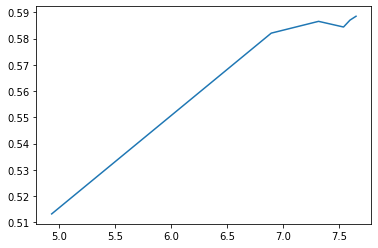


For L1 strength = 10000.00
F1 score for L1 model is 0.6161998334140804
[Logistic Regression] For C =0.5, F1 score: 0.6176123225076224, SSQ: [123.84856921 129.31203691 135.76433836 110.85845192]
[F1 score] 0.6176123225076224
[Vocab Length] 33513
[Log Vocab Length] 10.419688702238957



[10000, 0.6176123225076224, 33513, 10.419688702238957]

In [8]:
import math

def P6(c_l1=0.5, c_l2=0.5, ngram_range_param=(2,2), verbose=True):
    print()
    print(color.BOLD + color.RED + "For L1 strength = {:.2f}".format(c_l1) + color.END)
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    # prepare dataset
    vec = CountVectorizer(ngram_range=ngram_range_param)
    vec_result_train = vec.fit_transform(train_data)

    vec1 = CountVectorizer(ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.transform(dev_data)
    
    lr1 = LogisticRegression(C=c_l1, solver="liblinear", multi_class="auto", penalty="l1")
    lr1.fit(vec_result_train.toarray(), train_labels)
    predictions = lr1.predict(vec_result_dev.toarray())
    print("F1 score for L1 model is {0}".format(metrics.f1_score(dev_labels, predictions, average="weighted")))
    
    # print(lr1.coef_.shape)
    # Now we want the indices where atleast 1 value in the column is non zero
    # so extract the columns from np.nonzero and select the unique ones from them
    indices = np.nonzero(lr1.coef_)[1]
    indices = np.unique(indices)
    
    vocab = []
    # not optimal method, but we need to get the ngrams (features) corresponding to the indices
    for k,v in vec.vocabulary_.items():
        if v in indices:
            vocab.append(k)
    
    # build the new features with this vocab
    vec = CountVectorizer(ngram_range=ngram_range_param, vocabulary=vocab)
    vec_result_train = vec.fit_transform(train_data)
    
    vec1 = CountVectorizer(ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.transform(dev_data)
    
    # train the l2 logit
    logit_result = logistic_reg_helper([c_l2], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    
    # return the metrics as needed - L1 strength, f1 score, vocab len, log vocab len
    result = [c_l1, logit_result[c_l2][0], len(vocab), math.log(len(vocab))]
    if verbose:
        print("[F1 score] {0}".format(result[1]))
        print("[Vocab Length] {0}".format(result[2]))
        print("[Log Vocab Length] {0}".format(result[3]))
        print()
    
    return result
    

f1_chart = []
vocab_len = []
for i in np.arange(.1, 3, 0.5):
    [c_l1, f1, len_vocab, log_len_vocab] = P6(c_l1=i, verbose=True)
    f1_chart.append(f1)
    vocab_len.append(log_len_vocab)

plt.plot(vocab_len, f1_chart)
plt.show()
P6(c_l1=10000, verbose=True)

ANSWER:

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

As we see by increasing the value of c_l1, ie, the C value for the L1 model - for when we notice a relaxation in regularization, ie, we see the vocab length go up. For C=10,000 for example - ie, when model is hardly performing regularization, we notice the vocab length is 33513 - which is almost the full vocab. We notice that the L2 model does indeed perform better with full vocab (0.617) compared to when we have regularization / reduced vocabularies (0.58). 

However, its worth having regularization given that the improvement is not an extreme amount (0.58 to 0.617)

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7(ngram_range_param=(2,2), test_r=True, topN=3):
    c_l2 =100
    
    # prepare dataset using count vectorizer    
    vec = CountVectorizer(ngram_range=ngram_range_param)
    vec_result_train = vec.fit_transform(train_data)
    
    vec1 = CountVectorizer(ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.fit_transform(dev_data)
    
    print(color.BOLD + "[CountVectorizer]" + color.END + " Shape of the training set is {0}".format(str(vec_result_train.toarray().shape)))
    print(color.BOLD + "[CountVectorizer]" + color.END + " Shape of the dev set is {0}".format(str(vec_result_dev.toarray().shape)))
    
    logit_result_cv = logistic_reg_helper([c_l2], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    print(color.BOLD + "[CountVectorizer]" + color.END + " The F1 score is {0}".format(logit_result_cv[c_l2][0]))
    
    print()
    print()
    # prepare dataset using tf-idf
    vec = TfidfVectorizer(ngram_range=ngram_range_param)
    vec_result_train = vec.fit_transform(train_data)
    
    vec1 = TfidfVectorizer(ngram_range=ngram_range_param, vocabulary=vec.get_feature_names())
    vec_result_dev = vec1.fit_transform(dev_data)
    
    print(color.BOLD + "[Tf Idf]" + color.END + " Shape of the training set is {0}".format(str(vec_result_train.toarray().shape)))
    print(color.BOLD + "[Tf Idf]" + color.END + " Shape of the dev set is {0}".format(str(vec_result_dev.toarray().shape)))
    
    logit_result_tfidf = logistic_reg_helper([c_l2], vec_result_train.toarray(), vec_result_dev.toarray(), train_labels, dev_labels)
    print(color.BOLD + "[Tf Idf]" + color.END + " The F1 score is {0}".format(logit_result_tfidf[c_l2][0]))
    
    # below are the predicted probabilites
    # print(logit_result_tfidf[c_l2][3].shape)
    
    # below are the prediction labels
    # print(logit_result_tfidf[c_l2][4].shape)
    
    ratio_cv = []
    ratio_tfidf = []
    
    for idx in range(len(dev_labels)):
        r_cv = max(logit_result_cv[c_l2][3][idx]) / logit_result_cv[c_l2][3][idx][dev_labels[idx]]
        r_tfidf = max(logit_result_tfidf[c_l2][3][idx]) / logit_result_tfidf[c_l2][3][idx][dev_labels[idx]]
        ratio_cv.append((dev_labels[idx], logit_result_cv[c_l2][4][idx], r_cv))
        ratio_tfidf.append((dev_labels[idx], logit_result_tfidf[c_l2][4][idx], r_tfidf))
        if test_r:
            if dev_labels[idx] == logit_result_cv[c_l2][4][idx]:
                assert r_cv == 1.0
            if dev_labels[idx] == logit_result_tfidf[c_l2][4][idx]:
                assert r_tfidf == 1.0
    
    
    topN_r_idx_cv = []
    topN_r_idx_tfidf = []
    
    # https://www.geeksforgeeks.org/python-get-top-n-elements-from-records/
    for element in sorted(ratio_cv, key = lambda x: x[2], reverse = True)[:topN]:
        # get the index of the element so we can retrieve the corpus doc
        topN_r_idx_cv.append(ratio_cv.index(element))
    
    for element in sorted(ratio_tfidf, key = lambda x: x[2], reverse = True)[:topN]:
        # get the index of the element so we can retrieve the corpus doc
        topN_r_idx_tfidf.append(ratio_tfidf.index(element)) 
        
    #print(topN_r_idx_cv)
    #print(topN_r_idx_tfidf)
    
    
    for idx in topN_r_idx_tfidf:
        print()
        print(color.RED + color.BOLD + "The doc with index {0} has r-ratio {1} and was classified as {2} whereas ground truth was {3}".format(idx, ratio_tfidf[idx][2], newsgroups_train.target_names[ratio_tfidf[idx][1]], newsgroups_train.target_names[ratio_tfidf[idx][0]]) + color.END)
        print(dev_data[idx])


P7()

[CountVectorizer] Shape of the training set is (2034, 194891)
[CountVectorizer] Shape of the dev set is (676, 194891)
[Logistic Regression] For C =100, F1 score: 0.6160342132002051, SSQ: [1140.14834014 1181.93663048 1247.41753228 1145.60168679]
[CountVectorizer] The F1 score is 0.6160342132002051


[Tf Idf] Shape of the training set is (2034, 194891)
[Tf Idf] Shape of the dev set is (676, 194891)
[Logistic Regression] For C =100, F1 score: 0.6847820484197712, SSQ: [14266.22232617 14446.13101818 15625.33951056 13163.51409802]
[Tf Idf] The F1 score is 0.6847820484197712

The doc with index 215 has r-ratio 246.18818603864835 and was classified as comp.graphics whereas ground truth was talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by sev

ANSWER:

**𝑅𝑟𝑎𝑡𝑖𝑜 = 𝑚𝑎𝑥𝑖𝑚𝑢𝑚 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 ÷ 𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑒𝑑 𝑝𝑟𝑜𝑏𝑎𝑏𝑖𝑙𝑖𝑡𝑦 𝑜𝑓 𝑐𝑜𝑟𝑟𝑒𝑐𝑡 𝑙𝑎𝑏𝑒𝑙**

R ratio represents the correctness of our prediction. Lower values of this ratio are better.

If the highest predicted probability is the correct label, then the R ratio is 1.

If the incorrect label has the highest probability, then the ratio will be greater than 1. If our correct label probability is lower with respect to the incorrect label's probability, then the R ratio will be higher. The higher the R ratio, the more confidently we predicted the wrong class.


**CountVectorizer vs TfIdfVectorizer**

CountVectorizer just gives us the term frequencies in the data corpus for each n gram extracted. This will always be a positive integer value since counts can be integers only.

TfIdfVectorizer gives us the TfIdf score for each n gram extracted in the data corpus. This can be a positive fractional number.

The formula for tf-idf is _tf-idf(t) = tf(t,d) x idf(t)_


In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

To overcome this, we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

We see an improvement in score from 0.61 to 0.69 when using TF IDF instead of Counts.

**Where does the classifier make mistakes?**

From the above examples, its evident that the classifier is seeing words related to computers and classifying the text as "com.graphics", whereas its true label is "talk.religion.misc". For example, in both index 665 and 215 - the classifier is looking at words (features) like "ftp", "internet", "printer", "Microsoft Windows", email addresses etc. and is classifying the sample wrongly. 

One way to address this may be to overweight terms like "Mormon" and "Jesus" that may help in making the classifier predict the right class. 

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.